In [1]:
import torch
import gc
import easydict
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score

import hyperopt
from hyperopt import pyll, hp, fmin, tpe, STATUS_OK, Trials

from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from tqdm import tqdm


## Settings

In [2]:
# !pip install -q hyperopt
# !pip install -q easydict
# !pip install -q catboost
# !pip install -q xgboost
# !pip install -q lightgbm

In [3]:
def trials_to_df(trials, space, best):
    # 전체 결과
    rows = []
    keys = list(trials.trials[0]["misc"]["vals"].keys())

    # 전체 실험결과 저장
    for trial in trials:
        row = {}

        # tid
        tid = trial["tid"]
        row["experiment"] = str(tid)

        # hyperparameter 값 저장
        vals = trial["misc"]["vals"]
        hparam = {key: value[0] for key, value in vals.items()}

        # space가 1개 - 값을 바로 반환
        # space가 다수 - dict에 값을 반환
        hparam = hyperopt.space_eval(space, hparam)

        if len(keys) == 1:
            row[keys[0]] = hparam
        else:
            for key in keys:
                row[key] = hparam[key]

        # metric
        row["metric"] = abs(trial["result"]["loss"])

        # 소요 시간
        row["time"] = (trial["refresh_time"] - trial["book_time"]).total_seconds()

        rows.append(row)

    experiment_df = pd.DataFrame(rows)

    # best 실험
    row = {}
    best_hparam = hyperopt.space_eval(space, best)

    if len(keys) == 1:
        row[keys[0]] = best_hparam
    else:
        for key in keys:
            row[key] = best_hparam[key]
    row["experiment"] = "best"

    best_df = pd.DataFrame([row])

    # best 결과의 auc / time searching 하여 찾기
    search_df = pd.merge(best_df, experiment_df, on=keys)

    # column명 변경
    search_df = search_df.drop(columns=["experiment_y"])
    search_df = search_df.rename(columns={"experiment_x": "experiment"})

    # 가장 좋은 metric 결과 중 가장 짧은 시간을 가진 결과를 가져옴
    best_time = search_df.time.min()
    search_df = search_df.query("time == @best_time")

    df = pd.concat([experiment_df, search_df], axis=0)

    return df


In [4]:
### ratio 0.9
data = pd.read_csv('./data/opt_metadata.csv', index_col=0)
data

,bert,lstm,last_query,lstm_attn,saint,y
0,0.227665,0.033894,0.078204,0.076432,0.103042,0
1,0.962192,0.846531,0.952949,0.882752,0.934738,1
2,0.124927,0.023707,0.004816,0.029667,0.060086,0
3,0.677230,0.554693,0.603421,0.578528,0.447459,1
4,0.662673,0.314070,0.337882,0.599516,0.189820,0
...,...,...,...,...,...,...
6023,0.322990,0.259768,0.565327,0.395470,0.573913,1
6024,0.863316,0.892938,0.844286,0.893640,0.904047,1
6025,0.903101,0.622870,0.967828,0.812565,0.697296,1
6026,0.122226,0.467528,0.295091,0.385376,0.186934,0


In [5]:
X = data.drop(columns=['y']) ; y = data['y']

# collect out of sample predictions
rf_preds, lr_preds, cb_preds, xg_preds, lg_preds = list(), list(), list(), list(), list()
rf_submissions, lr_submissions, cb_submissions, xg_submissions, lg_submissions = list(), list(), list(), list(), list()

# fold_n = 5
# kfold = KFold(n_splits=fold_n, shuffle=False)

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.9, random_state=42)


bert = pd.read_csv('./data/bert2_submission.csv')['prediction']
lstm = pd.read_csv('./data/lstm2_submission.csv')['prediction']
lqtm = pd.read_csv('./data/hptine_LQTM_ver4.csv')['prediction']
lstm_attn = pd.read_csv('./data/hptune_LSTMATTN_ver3.csv')['prediction']
saint = pd.read_csv('./data/saint2_submission.csv')['prediction']

test_X = pd.concat([bert, lstm, lqtm, lstm_attn, saint], axis=1)
test_X.columns = ['bert', 'lstm', 'last_query', 'lstm_attn', 'saint']
test_X

,bert,lstm,last_query,lstm_attn,saint
0,0.611955,0.590942,0.716627,0.539600,0.594349
1,0.732885,0.859212,0.860638,0.842267,0.809390
2,0.271514,0.826183,0.407643,0.564495,0.105468
3,0.510138,0.699264,0.387272,0.432985,0.794482
4,0.415566,0.441082,0.382614,0.072084,0.450198
...,...,...,...,...,...
739,0.204499,0.203053,0.106188,0.071577,0.190448
740,0.922399,0.847281,0.797577,0.874298,0.850475
741,0.732162,0.791279,0.618865,0.802029,0.767869
742,0.711767,0.563954,0.712226,0.671481,0.619089


In [6]:
def metamodel_tune(space, objective_function, max_evals:int=2):
    # 최적화
    trials = Trials()
    best = fmin(
        fn=objective_function,  # 최적화 할 함수 (목적 함수)
        space=space,  # Hyperparameter 탐색 공간
        algo=tpe.suggest,  # 베이지안 최적화 적용 알고리즘 : Tree-structured Parzen Estimator (TPE)
        max_evals=max_evals,  # 입력 시도 횟수
        trials=trials,  # 시도한 입력 값 및 입력 결과 저장
        rstate=np.random.default_rng(seed=42),  ## fmin()을 시도할 때마다 동일한 결과를 가질 수 있도록 설정하는 랜덤 시드
    )

    print("best:", best)

    # Save
    result = trials_to_df(trials, space, best)
    result.sort_values(by="metric", ascending=False, inplace=True)
    result.reset_index(drop=True, inplace=True)
    os.makedirs('./result/', exist_ok=True)
    result.to_csv("./result/oof_tuning_result.csv", index=False)

    return result

## XGBoost

In [7]:
# 목적 함수
def xgb_objective_function(xgb_space):
    """
    space 예시 {'batch_size': 64, 'lr': 0.00010810929882981193, 'n_layers': 1}
    """
    # space 가 dict으로 건네지기 때문에 easydict으로 바꿔준다

    global X
    global y
    global valid_X 
    global valid_y

    # 캐시 메모리 비우기 및 가비지 컬렉터 가동!
    torch.cuda.empty_cache()
    gc.collect()

    xgb_space = easydict.EasyDict(xgb_space)

    # 하이퍼파라미터 값 변경
    n_estimators = int(xgb_space["n_estimators"])
    learning_rate = xgb_space["learning_rate"]
    max_depth = xgb_space["max_depth"]
    subsample = xgb_space["subsample"]
    colsample_bytree = xgb_space["colsample_bytree"]

    params = {'n_estimators':n_estimators,
              'learning_rate':learning_rate,
              'max_depth':max_depth,
              'subsample':subsample,
              'colsample_bytree':colsample_bytree,
              'early_stopping_rounds':100,
              'eval_metric':roc_auc_score,
              'tree_method':'gpu_hist',
              'gpu_id':0, 
              'random_state':42}
    
    model = XGBClassifier(**params)
    model.fit(train_X, train_y, eval_set=[(valid_X, valid_y)], verbose=0)
    preds = model.predict_proba(valid_X)[:, 1]
    targets = valid_y

    auc = roc_auc_score(targets, preds)

    return -1 * auc  # 목적 함수 값을 -auc로 설정 => 목적 함수 최소화 => auc 최대화

In [8]:
# 탐색 공간
xgb_space = {
    "n_estimators": hp.quniform("n_estimators", 100, 1000, 1),
    "learning_rate": hp.quniform("learning_rate", 0.001, 0.01, 0.001),
    "max_depth": hp.choice("max_depth", [3,4,5,6,7,8,9]),
    "subsample": hp.quniform("subsample", 0.5, 1.0, 0.1),
    "colsample_bytree": hp.quniform("colsample_bytree", 0.5, 1.0, 0.1)}

In [9]:
xgb_result = metamodel_tune(xgb_space, xgb_objective_function, max_evals=2)

100%|██████████| 2/2 [00:03<00:00,  1.70s/trial, best loss: -0.7607433395624992]
best: {'colsample_bytree': 0.8, 'learning_rate': 0.002, 'max_depth': 6, 'n_estimators': 647.0, 'subsample': 0.7000000000000001}


In [10]:
xgb_result

,experiment,colsample_bytree,learning_rate,max_depth,n_estimators,subsample,metric,time
0,1,0.8,0.002,9,647.0,0.7,0.760743,0.915
1,best,0.8,0.002,9,647.0,0.7,0.760743,0.915
2,0,0.9,0.007,6,658.0,0.9,0.744089,2.468


## LGBM

In [11]:
# 목적 함수
def lgbm_objective_function(lgbm_space):
    """
    space 예시 {'batch_size': 64, 'lr': 0.00010810929882981193, 'n_layers': 1}
    """
    # space 가 dict으로 건네지기 때문에 easydict으로 바꿔준다

    global X
    global y
    global valid_X 
    global valid_y

    # 캐시 메모리 비우기 및 가비지 컬렉터 가동!
    torch.cuda.empty_cache()
    gc.collect()

    lgbm_space = easydict.EasyDict(lgbm_space)

    # 하이퍼파라미터 값 변경
    n_estimators = int(lgbm_space["n_estimators"])
    learning_rate = lgbm_space["learning_rate"]
    max_depth = lgbm_space["max_depth"]
    num_leaves = int(lgbm_space["num_leaves"])
    min_child_samples = int(lgbm_space["min_child_samples"])

    params = {'n_estimators':n_estimators,
              'learning_rate':learning_rate,
              'max_depth':max_depth,
              'num_leaves':num_leaves,
              'min_child_samples':min_child_samples,
              'force_col_wise':True,
              'early_stopping_round':100,
              'verbose':-1,
              'random_state':42}
    
    model = LGBMClassifier(**params)
    model.fit(train_X, train_y, eval_set=[(valid_X, valid_y)], eval_metric='auc')
    preds = model.predict_proba(valid_X)[:, 1]
    targets = valid_y

    auc = roc_auc_score(targets, preds)

    return -1 * auc  # 목적 함수 값을 -auc로 설정 => 목적 함수 최소화 => auc 최대화

In [12]:
# 탐색 공간
lgbm_space = {
    "n_estimators": hp.quniform("n_estimators", 100, 500, 1),
    "learning_rate": hp.quniform("learning_rate", 0.001, 0.01, 0.001),
    "max_depth": hp.choice("max_depth", [3,4,5,6,7,8,9]),
    "num_leaves": hp.quniform("num_leaves", 7, 17, 1),
    "min_child_samples": hp.quniform("min_child_samples", 3, 9, 1)}

In [13]:
lgbm_result = metamodel_tune(lgbm_space, lgbm_objective_function, max_evals=100)

[1]	valid_0's auc: 0.756273	valid_0's binary_logloss: 0.691479
[2]	valid_0's auc: 0.756273	valid_0's binary_logloss: 0.689403
[3]	valid_0's auc: 0.756273	valid_0's binary_logloss: 0.687365
[4]	valid_0's auc: 0.756273	valid_0's binary_logloss: 0.685365
[5]	valid_0's auc: 0.756273	valid_0's binary_logloss: 0.683401
[6]	valid_0's auc: 0.756273	valid_0's binary_logloss: 0.681473
[7]	valid_0's auc: 0.75349	valid_0's binary_logloss: 0.679554
[8]	valid_0's auc: 0.755099	valid_0's binary_logloss: 0.677671
[9]	valid_0's auc: 0.755099	valid_0's binary_logloss: 0.675822
[10]	valid_0's auc: 0.754784	valid_0's binary_logloss: 0.67403
[11]	valid_0's auc: 0.754835	valid_0's binary_logloss: 0.672263
[12]	valid_0's auc: 0.754835	valid_0's binary_logloss: 0.670533
[13]	valid_0's auc: 0.754953	valid_0's binary_logloss: 0.668812
[14]	valid_0's auc: 0.75444	valid_0's binary_logloss: 0.66712
[15]	valid_0's auc: 0.757764	valid_0's binary_logloss: 0.665425
[16]	valid_0's auc: 0.758257	valid_0's binary_logloss

In [14]:
lgbm_result

,experiment,learning_rate,max_depth,min_child_samples,n_estimators,num_leaves,metric,time
0,best,0.009,3,6.0,389.0,7.0,0.801260,27.914
1,58,0.009,3,6.0,389.0,7.0,0.801260,27.914
2,81,0.007,3,8.0,499.0,7.0,0.801134,31.063
3,78,0.009,3,7.0,425.0,11.0,0.800840,28.457
4,71,0.009,3,7.0,412.0,11.0,0.800840,29.265
...,...,...,...,...,...,...,...,...
96,98,0.006,8,6.0,298.0,17.0,0.782130,2.143
97,34,0.006,6,6.0,152.0,16.0,0.781376,2.194
98,28,0.007,9,4.0,320.0,16.0,0.780990,14.669
99,11,0.003,8,4.0,343.0,15.0,0.780905,9.230


In [16]:
params = {'learning_rate': 0.009,
            'max_depth': 3,
            'min_child_samples': 6,
            'n_estimators': 389,
            'num_leaves': 7,
            'force_col_wise':True,
            'verbose':-1,
            'random_state':42}

lgbm_model = LGBMClassifier(**params)
lgbm_model.fit(X, y)
lgbm_submission = lgbm_model.predict_proba(test_X)[:, 1]

In [34]:
pd.DataFrame(np.array(lgbm_submission),columns=['prediction']).reset_index(drop=False).rename(columns={'index':'id'}).to_csv('./result/oofstacking_lgbm.csv',sep=',',index=False)

In [19]:
sota = pd.read_csv('sota.csv')['prediction']

In [69]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

gp = GaussianProcessClassifier(random_state=0)
gp.fit(X, y)
gp_submission = gp.predict_proba(test_X)

In [72]:
gp_submission = gp_submission[:,1]

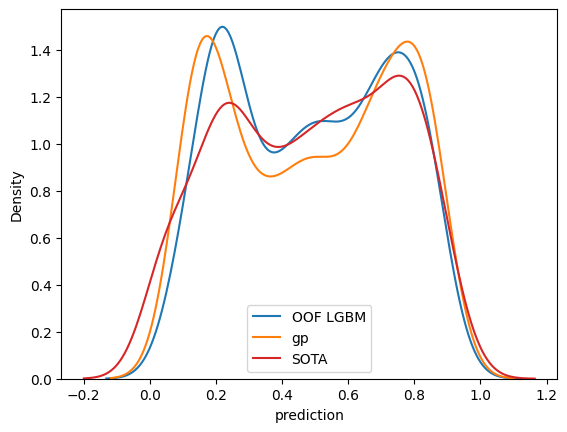

In [74]:
# sns.kdeplot(rf_submissions, label='RF')
# sns.kdeplot(lr_submissions, label='LR')
# sns.kdeplot(cb_submissions, label='CB')
# sns.kdeplot(xg_submissions, label='XG')
# sns.kdeplot(lg_submissions, label='LG')
sns.kdeplot(lgbm_submission, label='OOF LGBM')
# sns.kdeplot(lr_submission, label='OOF lr')
sns.kdeplot(gp_submission, label='gp')
sns.kdeplot()
sns.kdeplot(sota, label='SOTA')
plt.legend()
plt.show()